<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/12/1202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install umap-learn umap-learn[plot] kneed
!wget -O 0807_barcodes.tsv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0807_barcodes.tsv?raw=1
!wget -O 0807_genes.tsv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0807_genes.tsv?raw=1
!wget -O 0807_matrix.mtx https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0807_matrix.mtx?raw=1
!wget -O 0807_pmbc_3k_cell_types.json https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0807_pmbc_3k_cell_types.json?raw=1

## Single-cell rna data analysis - part 2

In [ ]:
import json

import pandas as pd
import numpy as np

from scipy.io import mmread

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

from yellowbrick.cluster import SilhouetteVisualizer

import umap
import umap.plot as uplot

from kneed import KneeLocator
import random

random.seed(12)

sns.set_theme()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

## Load the data

Single-cell RNA sequencing (scRNA-seq) is a technique used to study the gene expression patterns of individual cells.


In [ ]:
# Load the dataset
cell_names_path = '0807_barcodes.tsv'
gene_names_path = '0807_genes.tsv'
data_path = '0807_matrix.mtx'

cell_names = pd.read_csv(cell_names_path, sep='\t', header=None)[0]
gene_names = pd.read_csv(gene_names_path, sep='\t', header=None)[1]

In [ ]:
# Load cell annotations
cell_annotations_path = '0807_pmbc_3k_cell_types.json'
with open(cell_annotations_path, 'r') as fle:
    cell_type_dict = json.load(fle)

In [ ]:
cell_type_dict

{'AAACATACAACCAC-1': 'Memory CD4 T',
 'AAACATTGAGCTAC-1': 'B-cells',
 'AAACATTGATCAGC-1': 'Memory CD4 T',
 'AAACCGTGCTTCCG-1': 'CD14+ Mono',
 'AAACCGTGTATGCG-1': 'NK cells',
 'AAACGCACTGGTAC-1': 'Memory CD4 T',
 'AAACGCTGACCAGT-1': 'CD8 T',
 'AAACGCTGGTTCTT-1': 'CD8 T',
 'AAACGCTGTAGCCA-1': 'Naive CD4 T',
 'AAACGCTGTTTCTG-1': 'FCGR3A+ Mono',
 'AAACTTGAAAAACG-1': 'B-cells',
 'AAACTTGATCCAGA-1': 'Naive CD4 T',
 'AAAGAGACGAGATA-1': 'Naive CD4 T',
 'AAAGAGACGCGAGA-1': 'CD14+ Mono',
 'AAAGAGACGGACTT-1': 'Naive CD4 T',
 'AAAGAGACGGCATT-1': 'Naive CD4 T',
 'AAAGCAGATATCGG-1': 'CD14+ Mono',
 'AAAGCCTGTATGCG-1': 'Memory CD4 T',
 'AAAGGCCTGTCTAG-1': 'B-cells',
 'AAAGTTTGATCACG-1': 'B-cells',
 'AAAGTTTGGGGTGA-1': 'B-cells',
 'AAAGTTTGTAGAGA-1': 'Naive CD4 T',
 'AAAGTTTGTAGCGT-1': 'CD14+ Mono',
 'AAATCAACAATGCC-1': 'B-cells',
 'AAATCAACACCAGT-1': 'Naive CD4 T',
 'AAATCAACCAGGAG-1': 'Naive CD4 T',
 'AAATCAACCCTATT-1': 'FCGR3A+ Mono',
 'AAATCAACGGAAGC-1': 'Naive CD4 T',
 'AAATCAACTCGCAA-1': 'Memory 

In [ ]:
# Show cell names
cell_names.head()

,0
0,AAACATACAACCAC-1
1,AAACATTGAGCTAC-1
2,AAACATTGATCAGC-1
3,AAACCGTGCTTCCG-1
4,AAACCGTGTATGCG-1


In [ ]:
# Show gene names
gene_names.head()

,1
0,MIR1302-10
1,FAM138A
2,OR4F5
3,RP11-34P13.7
4,RP11-34P13.8


In [ ]:
# Load expression matrix
expression_mtx = mmread(data_path)

In [ ]:
# Write shapes
print('Expression shape : {}'.format(expression_mtx.shape))
print('Num cells : {}'.format(cell_names.shape[0]))
print('Num genes : {}'.format(gene_names.shape[0]))

Expression shape : (32738, 2700)
Num cells : 2700
Num genes : 32738


In [ ]:
# Create dataframe from sparse matrix
expression_df = pd.DataFrame.sparse.from_spmatrix(
    expression_mtx,
    columns=cell_names.values,
    index=gene_names.values
)

In [ ]:
expression_df.iloc[1300:1320, 1100:1120]

,CCGCTATGTGCAAC-1,CCGCTATGTGCACA-1,CCGGTACTGTCCTC-1,CCGTACACAAGCAA-1,CCGTACACAGCGTT-1,CCGTACACGTCATG-1,CCGTACACGTTGGT-1,CCGTACACTAACGC-1,CCTAAACTTTCGTT-1,CCTAAGGACCCAAA-1,CCTAAGGACTAGCA-1,CCTAAGGAGGGCAA-1,CCTAAGGATGATGC-1,CCTAAGGATGTCAG-1,CCTACCGACTCTTA-1,CCTACCGAGGGATG-1,CCTAGAGAGGTGAG-1,CCTATAACCAAAGA-1,CCTATAACGAGACG-1,CCTATAACTCAGAC-1
RP11-131L23.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RP11-290M5.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CYR61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RP11-290M5.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ZNHIT6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
COL24A1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ODF2L,0,0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0
CLCA2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CLCA1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CLCA4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Quality controll

In [ ]:
# Get sum for all genes/cels
gene_sum = expression_df.sum(axis=1)
cell_sum = expression_df.sum(axis=0)

# Remove all genes that are not expressed (expression is equal to zero in all cells)
expression_df = expression_df.loc[
    gene_sum[gene_sum>3].index,
    cell_sum[cell_sum>10].index
].sparse.to_dense().T

In [ ]:
expression_df.shape

(2700, 13164)

In [ ]:
# Detect mitohondrial genes
mito_genes = [gene for gene in expression_df.columns if gene.startswith('MT-')]
mito_df = expression_df.loc[:, mito_genes]

# Calculate values that will be QC-ed
mito_df_sum = mito_df.sum(axis=1)
expression_df_sum = expression_df.sum(axis=1)
expression_df_num_genes = (expression_df>0).sum(axis=1)

percent_mt = mito_df_sum/expression_df_sum*100

In [ ]:
# Function for median deviation calculation
def mad_qc(data, limit='upper'):

    # Calculate the median of the data
    median = np.median(data)

    # Calculate the absolute deviations from the median
    absolute_deviations = np.abs(data - median)

    # Calculate the median absolute deviation
    mad = np.median(absolute_deviations)

    if limit == 'upper':

        upper_limit = median + 3*mad
        return data > upper_limit

    elif limit =='lower':

        lower_limit = median - 3*mad
        return data < lower_limit

    else:
        raise Exception('Incorrect choice for limit')

In [ ]:
# Perform QC based on three criteria
mito_qc = mad_qc(percent_mt, limit='upper')
expression_sum_qc = mad_qc(expression_df_sum, limit='lower')
num_genes_qc = mad_qc(expression_df_num_genes, limit='lower')

final_qc = mito_qc | expression_sum_qc | num_genes_qc

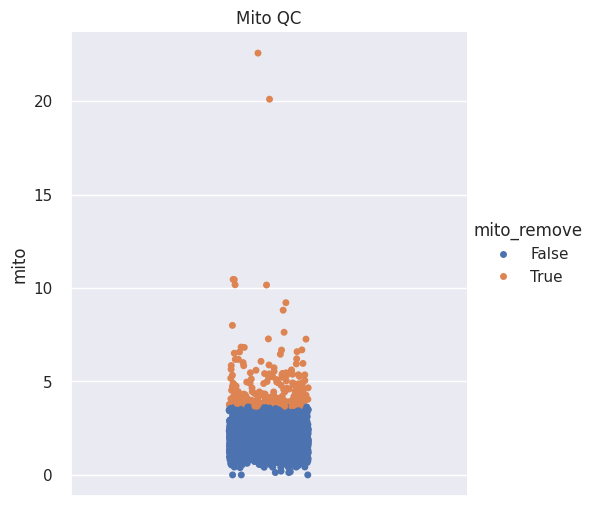

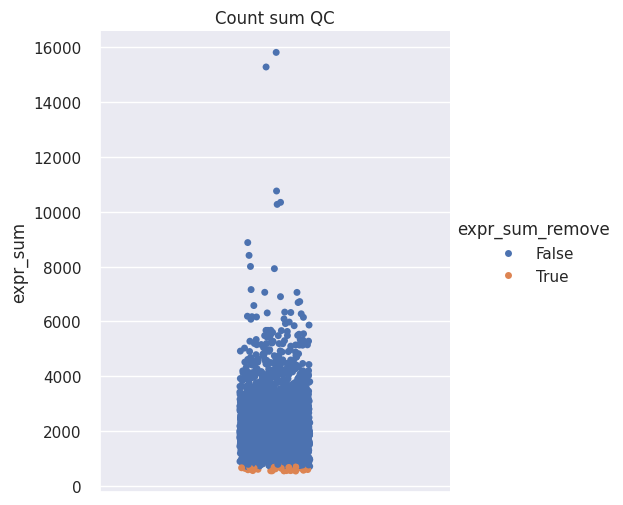

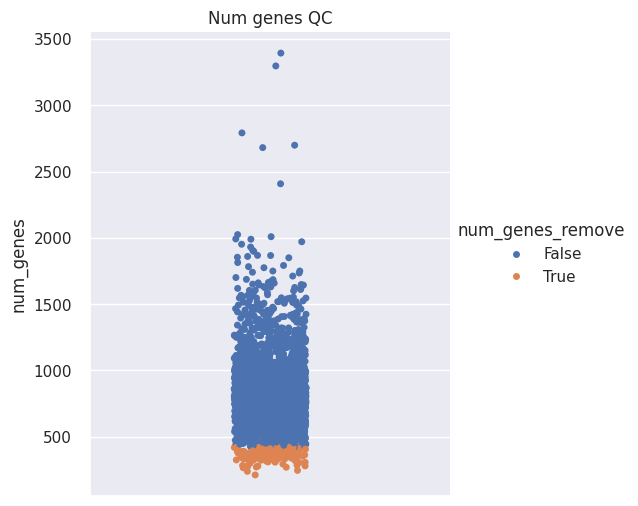

In [ ]:
# Concatenate all QC data and QC results into
# a single dataframe
qc_df = pd.concat(
    [
        percent_mt.to_frame(name='mito'),
        expression_df_sum.to_frame(name='expr_sum'),
        expression_df_num_genes.to_frame(name='num_genes'),
        mito_qc.to_frame(name='mito_remove'),
        expression_sum_qc.to_frame(name='expr_sum_remove'),
        num_genes_qc.to_frame(name='num_genes_remove')
    ],
    axis=1
)

# Plot results
sns.catplot(qc_df, y='mito',hue='mito_remove').set(title='Mito QC')
sns.catplot(qc_df, y='expr_sum',hue='expr_sum_remove').set(title='Count sum QC')
sns.catplot(qc_df, y='num_genes',hue='num_genes_remove').set(title='Num genes QC')

In [ ]:
# Print number of eliminated and retained cells (data points)
final_qc.value_counts()

,count
False,2411
True,289


In [ ]:
# Drop low quality points
expression_df = expression_df.drop(
    index=final_qc[final_qc==True].index,
    errors='ignore'
)

In [ ]:
# Remove cells without labels
cells_with_no_label = set(expression_df.index) - set(cell_type_dict.keys())
expression_df = expression_df.drop(index=cells_with_no_label)

### Normalization


In [ ]:
# Normalize expression of all genes in each cell with sum of gene expression in
# the cell
expression_df = expression_df.div(
    expression_df_sum[expression_df.index],
    axis=0
)*10000


Text(0, 0.5, 'Variance')

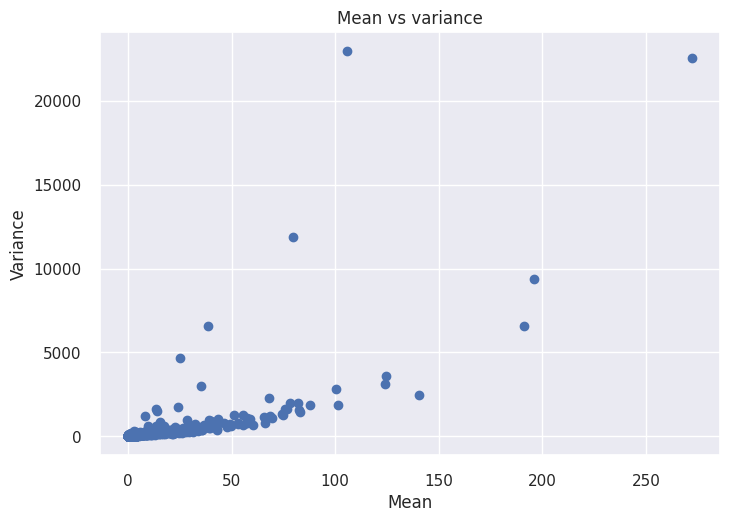

In [ ]:
gene_mean = expression_df.mean(axis=0)
gene_var =  expression_df.var(axis=0)

plt.scatter(gene_mean.values, gene_var.values)
plt.title('Mean vs variance')
plt.xlabel('Mean')
plt.ylabel('Variance')

Text(0, 0.5, 'Variance')

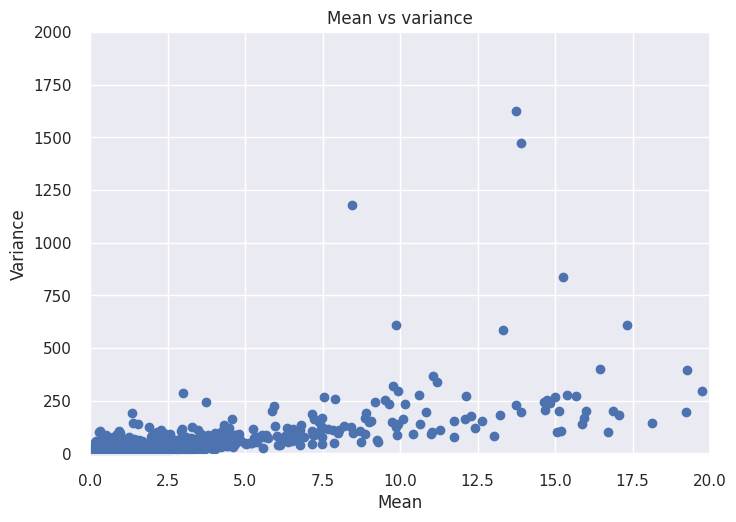

In [ ]:
plt.scatter(gene_mean.values, gene_var.values)
plt.ylim([-10, 2000])
plt.xlim([0, 20])
plt.title('Mean vs variance')
plt.xlabel('Mean')
plt.ylabel('Variance')

Text(0, 0.5, 'Count')

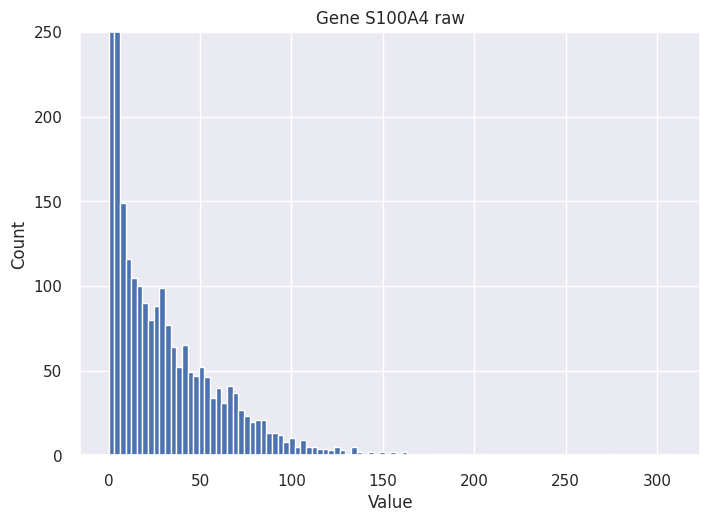

In [ ]:
expression_df['S100A4'].hist(bins=100)
plt.ylim([0,250])
plt.title('Gene S100A4 raw')
plt.xlabel('Value')
plt.ylabel('Count')

In [ ]:
# Log normalize the data in order to
# minimize effects of large values
expression_df = np.log(expression_df + 1)

full_expression_df = expression_df.copy()

Text(0, 0.5, 'Log - Variance')

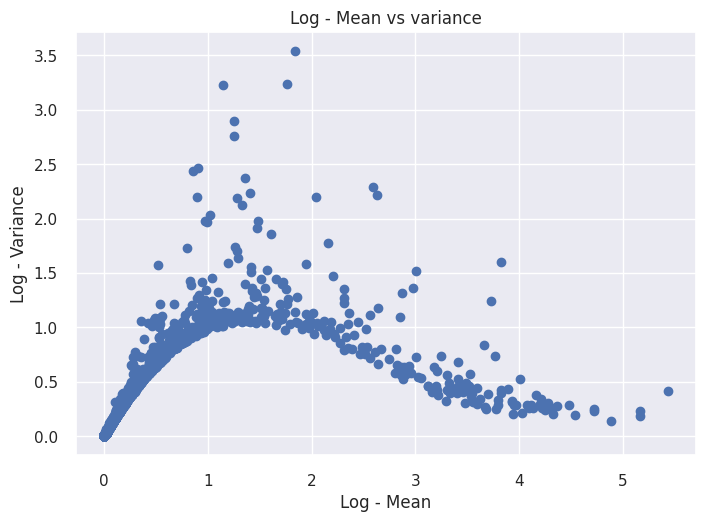

In [ ]:
gene_mean = expression_df.mean(axis=0)
gene_var =  expression_df.var(axis=0)


plt.scatter(gene_mean.values, gene_var.values)
plt.title('Log - Mean vs variance')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Variance')

Text(0, 0.5, 'Log - Count')

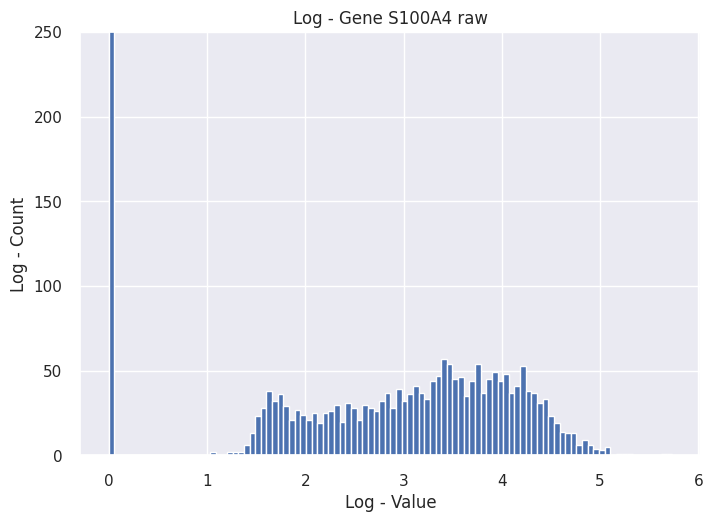

In [ ]:
expression_df['S100A4'].hist(bins=100)
plt.ylim([0,250])
plt.title('Log - Gene S100A4 raw')
plt.xlabel('Log - Value')
plt.ylabel('Log - Count')

### Feature selection

In [ ]:
# Add everything to data frame
gene_df = pd.concat([gene_mean, gene_var], axis=1)
gene_df.columns = ['mean', 'var']

# Bin the data
num_bins = 20
bin_labels = [i for i in range(num_bins)]
gene_df['bin'] = pd.cut(gene_df['mean'], bins=num_bins, labels=bin_labels)

In [ ]:
gene_df['bin'].value_counts()

,count
bin,
0,11846
1,752
2,201
3,106
4,55
5,36
6,25
13,17
10,17


Text(0, 0.5, 'Log - Variance')

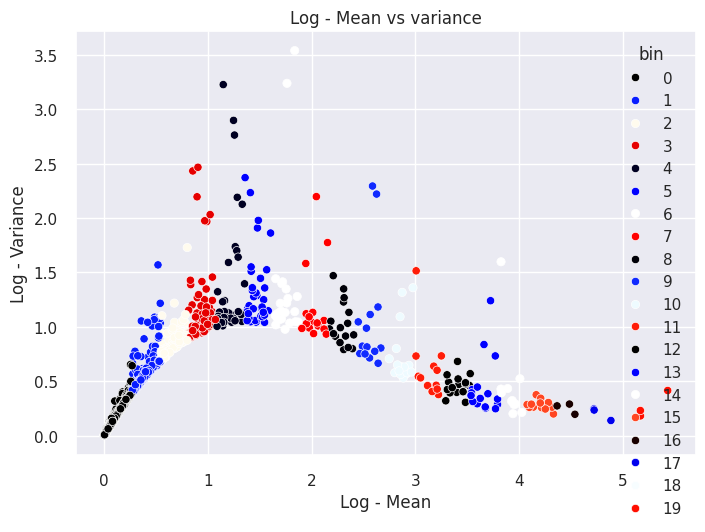

In [ ]:
sns.scatterplot(gene_df, x='mean', y='var', hue='bin', palette='flag')
plt.title('Log - Mean vs variance')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Variance')

In [ ]:
# Find variance to mean ratio
gene_df['dispersion'] = gene_df['var'] / gene_df['mean']

In [ ]:
# Find mean and standard deviati
gene_df_grouped = gene_df.groupby('bin')['dispersion']
bin_means = gene_df_grouped.mean()
bin_stds = gene_df_grouped.std(ddof=1)

<ipython-input-35-3be7c20b0448>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df_grouped = gene_df.groupby('bin')['dispersion']


In [ ]:
# Normalize dispersion inside each bin
gene_df['dispersions_norm'] = (
    gene_df['dispersion'].to_numpy() - bin_means[gene_df['bin'].to_numpy()].to_numpy()
) / bin_stds[gene_df['bin'].to_numpy()].to_numpy()

ValueError: cannot reindex on an axis with duplicate labels

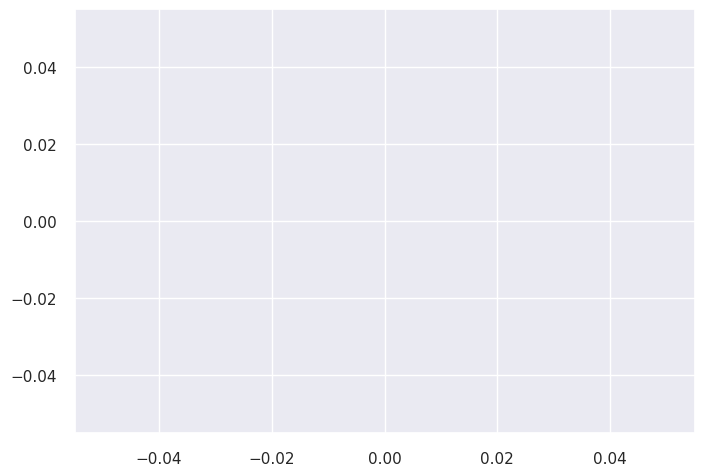

In [ ]:
sns.scatterplot(gene_df, x='mean', y='dispersions_norm')

plt.title('Log - Mean vs custom dispersion')
plt.xlabel('Log - Mean')
plt.ylabel('Log - Custom dispersion')

In [ ]:
# Sort genes by coefficient of variation
gene_df = gene_df.sort_values('dispersions_norm', ascending=False)

# Keep 2000 genes with highest coefficient of variation
highly_variable_genes = gene_df.index[:2000]

# Subset the expression matrix to highly variable genes
expression_df = expression_df.loc[:, highly_variable_genes]

## Dimensionality reduction

PCA is initially performed to denoise the data and reduce its computational complexity. By retaining only a subset of the top principal components, we can capture the essential structure of the data while removing the noise and reducing the dimensionality. This step not only improves the efficiency of downstream analyses but also helps to mitigate the effects of technical artifacts.

Following PCA, the UMAP (Uniform Manifold Approximation and Projection) algorithm is employed to visualize the single-cell data in a two-dimensional space.

In [ ]:
# Run PCA
pca = PCA()
pca_transformed_data = pca.fit_transform(expression_df.values)

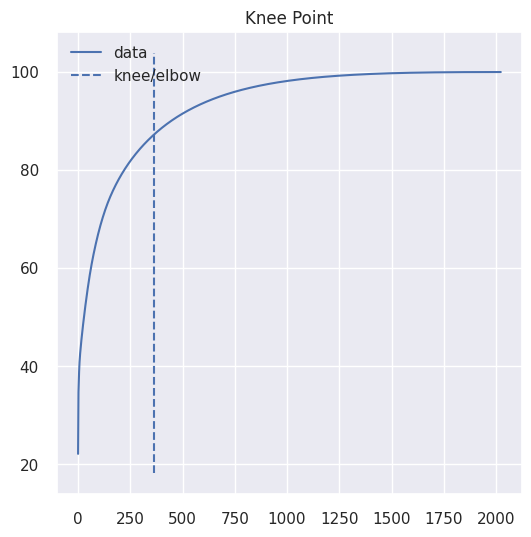

In [ ]:
# Perform knee detection
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)),
    cumulative_explained_variance,
    S=1.0,
    curve="concave",
    direction="increasing"
)
kneedle.plot_knee()

Number of principal components is choosen to be 50. This is frequent choice for this analysis type.

In [ ]:
# Extract subset of principal components
elbow_point = kneedle.elbow
pca_transformed_data = pca_transformed_data[:,:50]

In [ ]:
# Run umap
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(pca_transformed_data)


### Types of Cells and Their Characteristics

- **B Cells**
  - **What They Do**: Make "tags" (antibodies) that stick to germs and mark them for destruction.
  - **Main Role**: Help the immune system recognize and remember germs.
  - **Why Different**: Only cells that make antibodies to tag specific germs.

<!-- Empty Line After Main Bullet -->


- **Dendritic Cells (DCs)**
  - **What They Do**: Capture germs and show pieces to other immune cells.
  - **Main Role**: Alert the immune system about invaders.
  - **Why Different**: Messengers between the first-line and specialized immune defenses.

<!-- Empty Line After Main Bullet -->


- **CD14+ Monocytes**
  - **What They Do**: Suck up germs, break them apart, and can change into macrophages.
  - **Main Role**: Clean up and later transform into tissue-specific cells for ongoing defense.
  - **Why Different**: Versatile; can transform and become part of tissue defenses.

<!-- Empty Line After Main Bullet -->


- **FCGR3A+ Monocytes**
  - **What They Do**: Work with antibodies to make them more effective at tagging germs.
  - **Main Role**: Boost the effectiveness of antibodies.
  - **Why Different**: Have a special "hook" (FCGR3A) that enhances their cooperation with antibodies.

<!-- Empty Line After Main Bullet -->


- **Natural Killer (NK) cells**
  - **What They Do**: Patrol and kill infected or cancerous cells without needing specific tags.
  - **Main Role**: Quick response to a wide range of problems.
  - **Why Different**: Can act without needing to recognize specific germs.

<!-- Empty Line After Main Bullet -->


- **CD8 T cells**
  - **What They Do**: Directly kill infected or cancerous cells.
  - **Main Role**: Eliminate specifically tagged cells.
  - **Why Different**: The "assassins" that directly kill target cells.

<!-- Empty Line After Main Bullet -->


- **Naive CD4 T cells**
  - **What They Do**: Wait to be activated to fight specific germs.
  - **Main Role**: Ready to be trained for fighting specific invaders.
  - **Why Different**: Untrained soldiers waiting for their first mission.

<!-- Empty Line After Main Bullet -->


- **Memory CD4 T cells**
  - **What They Do**: Remember past germs and react faster next time.
  - **Main Role**: Quick response to known threats.
  - **Why Different**: The immune system's "record keepers."

<!-- Empty Line After Main Bullet -->


- **Platelets**
  - **What They Do**: Help blood to clot.
  - **Main Role**: Stop bleeding.
  - **Why Different**: Not directly involved in fighting germs but crucial for preventing blood loss.



<Axes: >

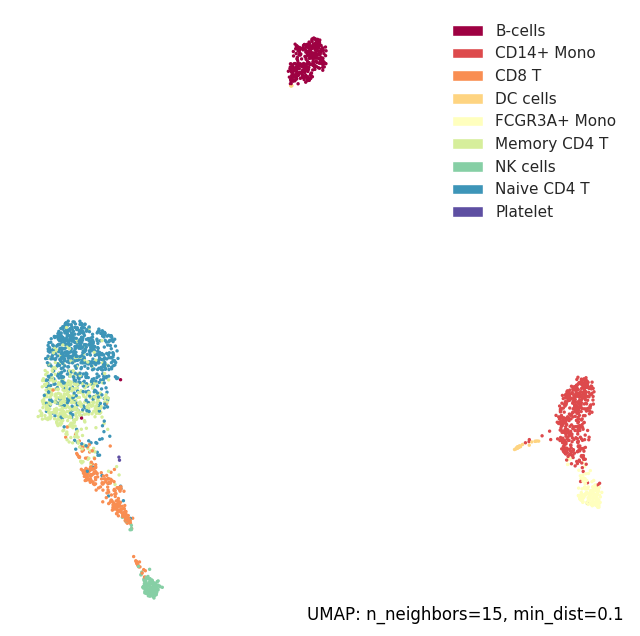

In [ ]:
# Plot umap embedding and display cell types
labels = [cell_type_dict[cell_id] if cell_id in cell_type_dict else 'none' for cell_id in expression_df.index ]
uplot.points(umap_obj, labels=np.array(labels))

## Attempt to cluster the data with K-means

In [ ]:
inertia_list = []
silhouette_score_list = []

# List used to store clusterings
clustering_result_dict = {}

# List used to store k means objects
k_means_list = []

num_clusters = range(3,15)

for num_clust in num_clusters:
    # Perform clustering for current number of clusters
    kmeans = KMeans(n_clusters=num_clust, n_init='auto', random_state=42)
    kmeans.fit(pca_transformed_data)

    k_means_list.append(kmeans)

    # Calculate inertia
    inertia_list.append(kmeans.inertia_)

    # Add clustering result to list
    silhouette_scr = silhouette_score(pca_transformed_data, kmeans.labels_)
    silhouette_score_list.append(silhouette_scr)

    clustering_result_dict[num_clust] = np.array(kmeans.labels_)

Text(0, 0.5, 'Silhouette score value')

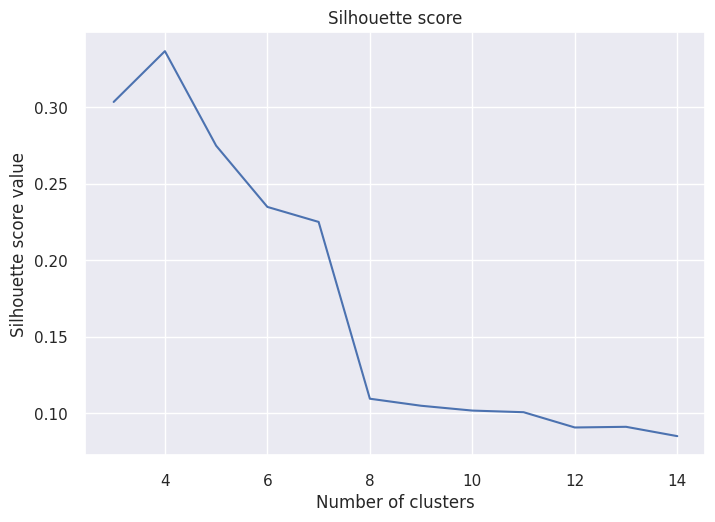

In [ ]:
# Siluethe plot
plt.plot(num_clusters, silhouette_score_list)
plt.title('Silhouette score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score value')

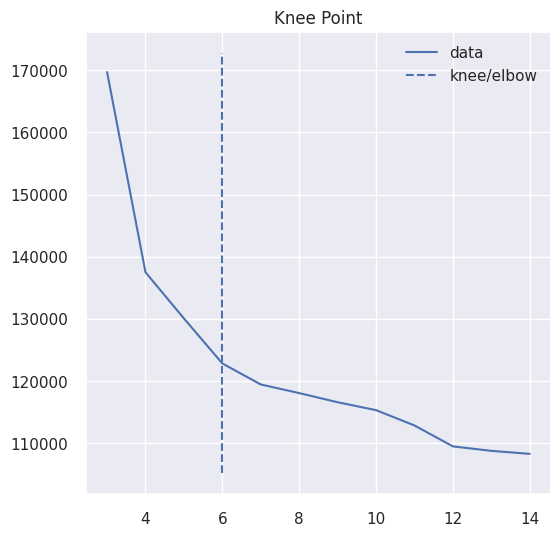

In [ ]:
# Plot inertia plot and curve
kneedle = KneeLocator(
    num_clusters,
    inertia_list,
    S=2,
    curve="convex",
    direction="decreasing"
)
kneedle.plot_knee()

<Axes: >

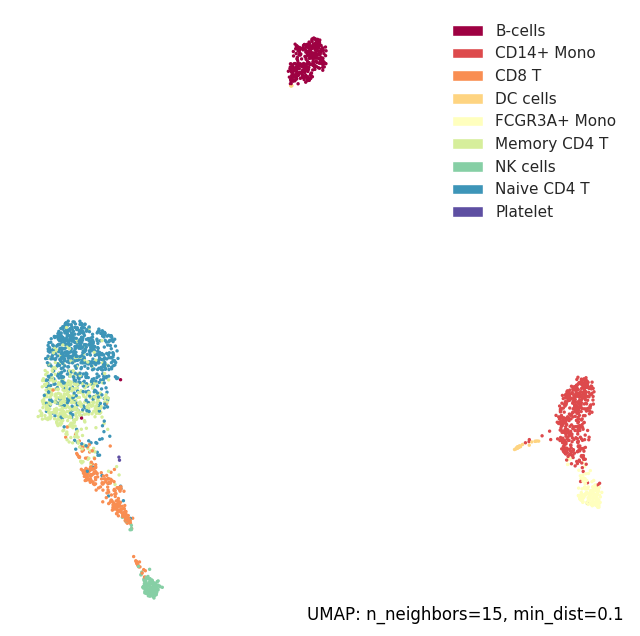

In [ ]:
uplot.points(umap_obj, labels=np.array(labels))
# we have three main groups of data points, each containing several cell types

<Axes: >

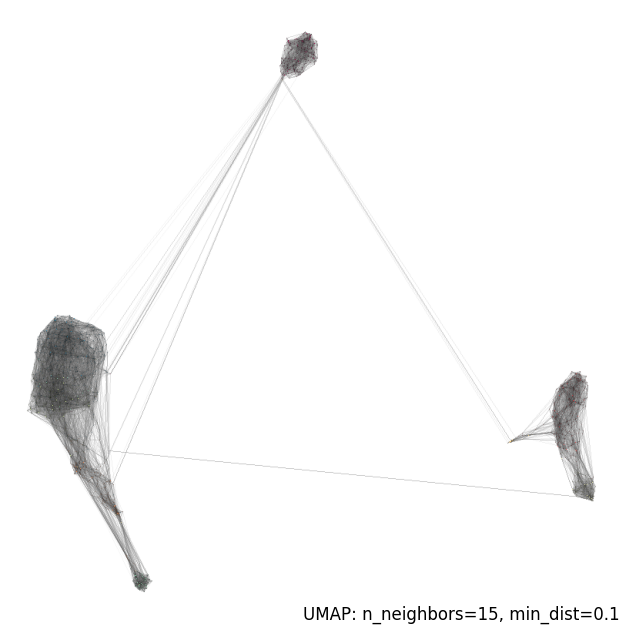

In [ ]:
umap.plot.connectivity(umap_obj, show_points=True,labels=np.array(labels))
# if we proceed to the Umap diagnostics we can see that these three major groups are not well connected to each other,
# meaning that we cannot bring conclusions about relationships between these groups based on our Umap embedding

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

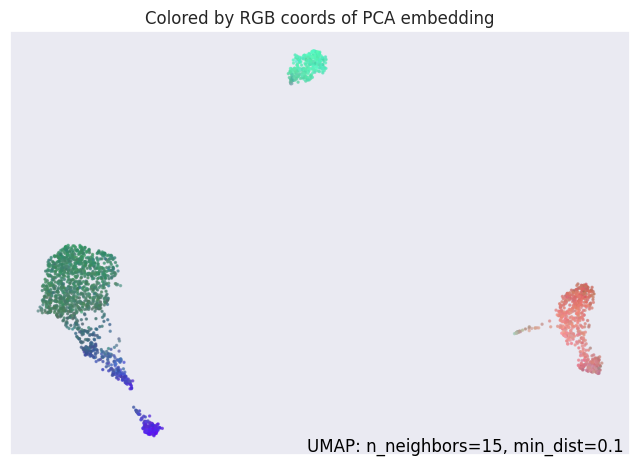

In [ ]:
umap.plot.diagnostic(umap_obj, diagnostic_type='pca')

Text(0.5, 1.0, 'Adjusted rand score')

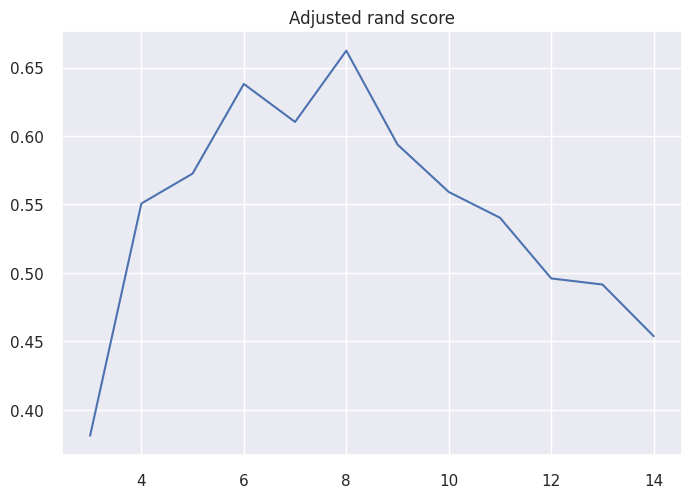

In [ ]:
adj_rand_score_list = []
for clust_num in clustering_result_dict:
    adj_rand_score_list.append(adjusted_rand_score(clustering_result_dict[clust_num], labels))

plt.plot(clustering_result_dict.keys(), adj_rand_score_list)
plt.title('Adjusted rand score')
# once we cluster the data by using K-means, you can see that at some values of k, the adjusted rand score will be quite high

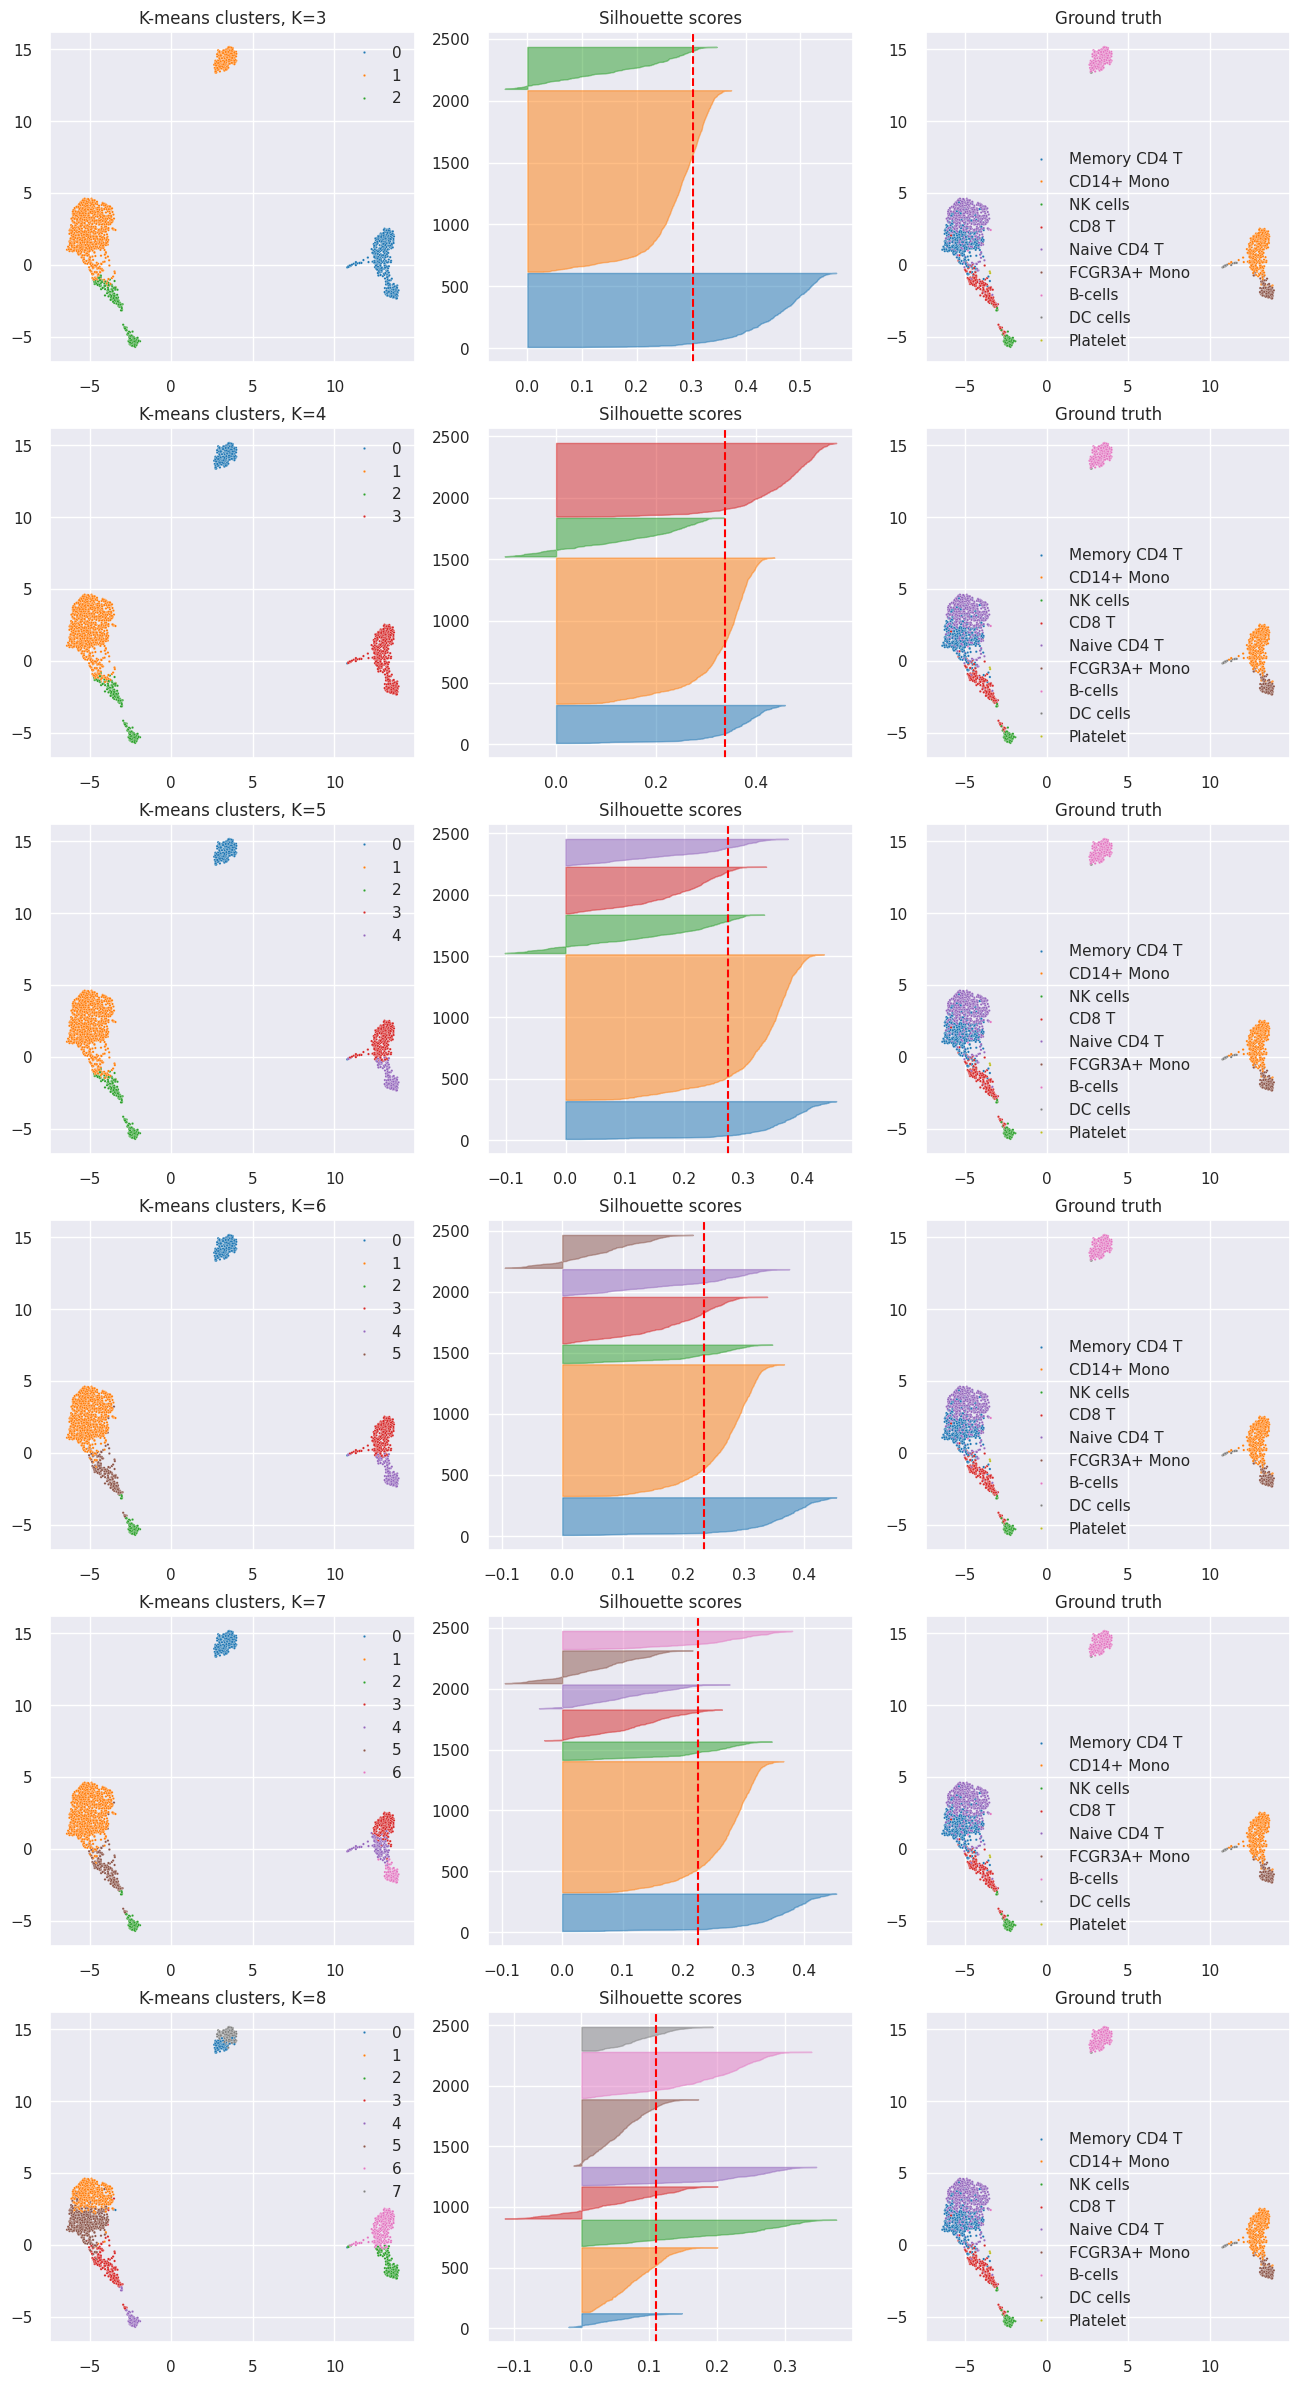

In [ ]:
# Initialize the grid
num_clust_list = [3,4,5,6,7,8]

fig, axs = plt.subplots(
    len(num_clust_list), 3,
    figsize=(16, 30)
)

tab10 = list(matplotlib.colormaps['tab10'].colors)

# Loop to populate the grid with plots
for i in range(len(num_clust_list)):
    sns.scatterplot(
        x=embedding[:,0],
        y=embedding[:,1],
        hue=clustering_result_dict[num_clust_list[i]],
        ax=axs[i, 0],
        s=3, palette='tab10'
    )

    visualizer = SilhouetteVisualizer(
        k_means_list[i],
        is_fitted=True,
        colors=tab10,
        ax=axs[i, 1]
    )

    visualizer = visualizer.fit(pca_transformed_data)

    sns.scatterplot(
        x=embedding[:,0],
        y=embedding[:,1],
        hue=np.array(labels),
        ax=axs[i, 2],
        s=3, palette='tab10'
    )
    axs[i,0].set_title('K-means clusters, K={}'.format(num_clust_list[i]))
    axs[i,1].set_title('Silhouette scores')
    axs[i,2].set_title('Ground truth')

plt.show()
# at certain values of k such as k equals seven, the algorithm will actually perform quite well
# K-means will manage to nicely separate all of these cell types (left bottom),
# will identify this cell type (middle top), and will manage to some extent to even identify cell types from this region (right bottom),
# but will generally fail in finding the right split

### Agglomerative clustering

In [ ]:
%%capture
!wget -O ch_9_funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0914_funcs.py?raw=1

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from ch_9_funcs import cophenetic_corr

linkage_matrix = linkage(
    pca_transformed_data,
    method='ward'
)

In [ ]:
cophenetic_corr(
    linkage_matrix=linkage_matrix,
    data_mtx =pca_transformed_data
)
# we will check our cophenetic correlation which is satisfactory

Cophenetic correlation : 0.8916196819442953


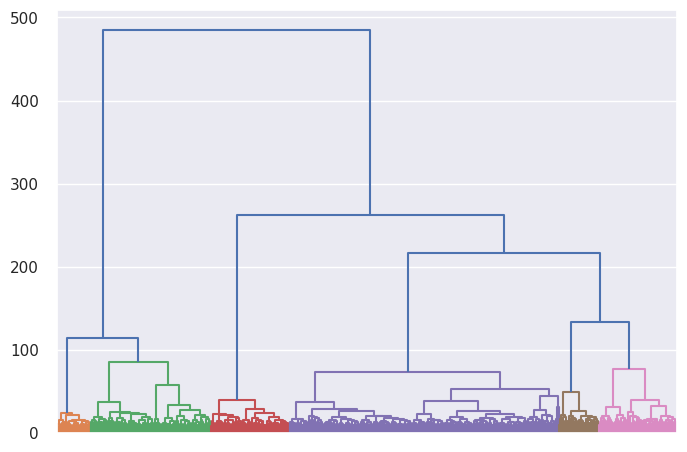

In [ ]:
_ = dendrogram(
    linkage_matrix,
    no_labels=True,
    color_threshold=90
)
# choosing a value of six for number of clusters might be a good idea

In [ ]:
clusters = fcluster(Z=linkage_matrix, t=8, criterion='maxclust')

0.5881673955448925


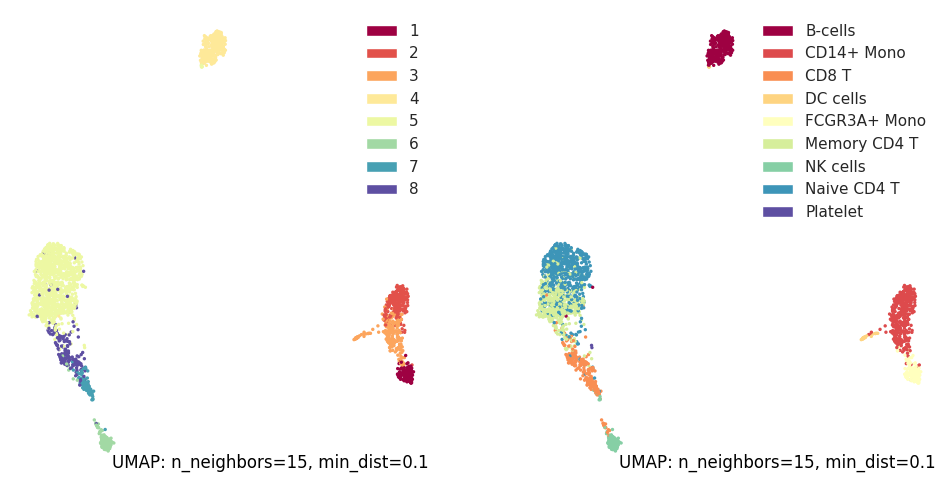

In [ ]:
fig, axs = plt.subplots(
    1,2,
    figsize=(12, 6)
)

uplot.points(umap_obj, labels=np.array(clusters), ax=axs[0])
uplot.points(umap_obj, labels=np.array(labels), ax=axs[1])

print(
    adjusted_rand_score(
        clusters,
        labels
    )
)
plt.show()
# the algorithm will actually manage to split this to some extent (left bottom), but again will fail to split this big group (NK cells, Naive CD4 T)
# algorithm will over split this group (right bottom) and will still nicely identify this group (middle top)
# it seems that even though the algorithm doesn't perform a bad, it's still it still performs a worse compared to K-means

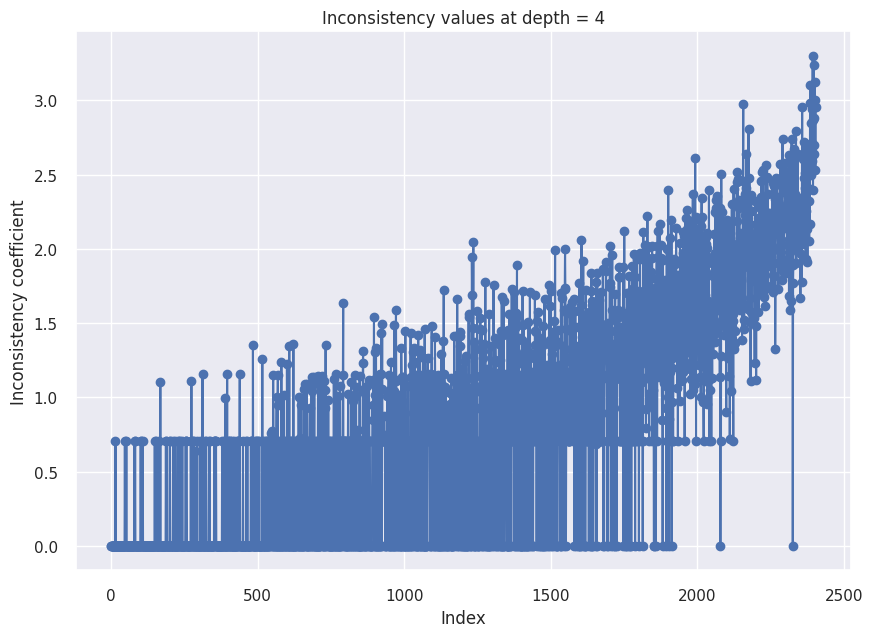

In [ ]:
# Calculate inconsistence matrix
depth=4
incosistent_mtx = inconsistent(linkage_matrix,depth)

# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))
plt.plot(incosistent_mtx[:,-1])
plt.scatter(range(incosistent_mtx.shape[0]),incosistent_mtx[:,-1])
plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show()

In [ ]:
# Perform clustering based on inconsistency
# and print clusters
clusters = fcluster(Z=linkage_matrix, t=3.1 , criterion='inconsistent', R=incosistent_mtx)
clusters
# 9 clusters

array([9, 3, 1, ..., 2, 2, 3], dtype=int32)

0.592277878772904


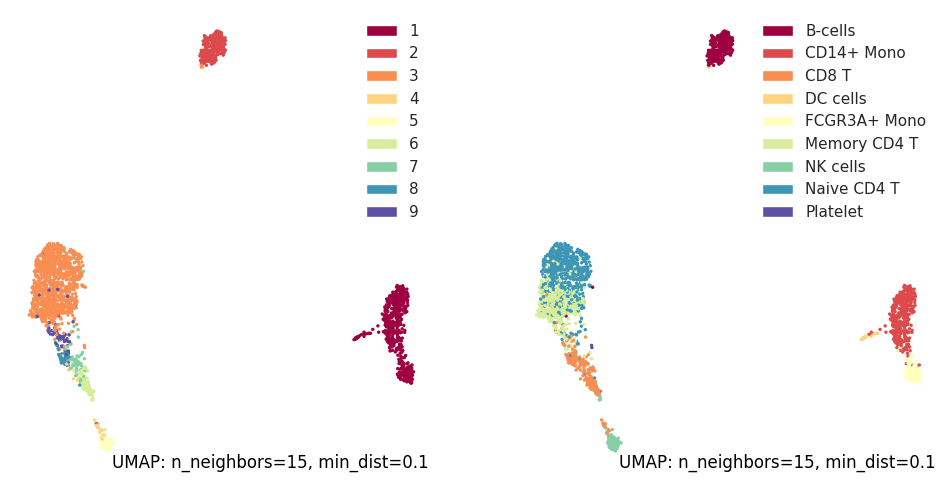

In [ ]:
fig, axs = plt.subplots(
    1,2,
    figsize=(12, 6)
)

uplot.points(umap_obj, labels=np.array(clusters), ax=axs[0])
uplot.points(umap_obj, labels=np.array(labels), ax=axs[1])

print(
    adjusted_rand_score(
        clusters,
        labels
    )
)
plt.show()
# this performs worse compared to choosing a number of clusters and performing a flat cut
# the agglomerative clustering didn't perform a bad, but it did perform worse compared to K-means

### HDBSCAN

In [ ]:
%%capture
!pip install hdbscan

In [ ]:
import hdbscan

0.46144362562192914


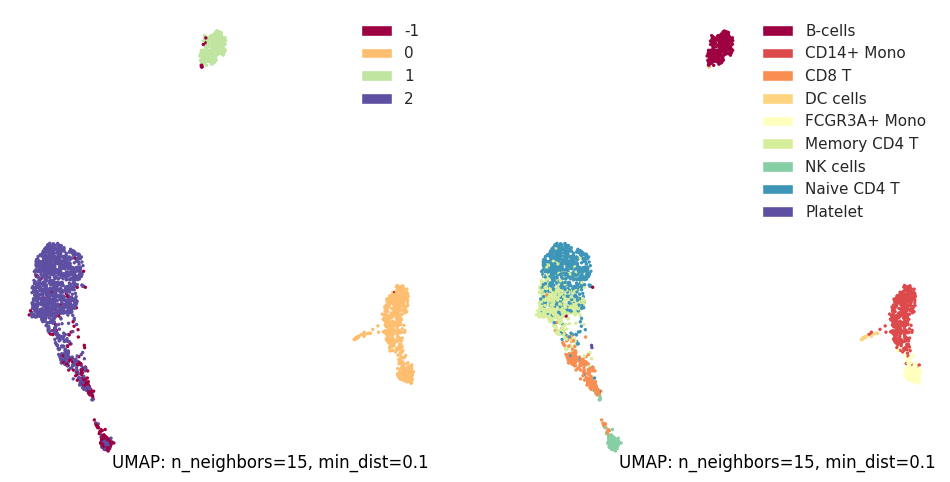

In [ ]:
# Run DBSCAN
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=200,
    metric='euclidean'
)
clusterer.fit(pca_transformed_data)

fig, axs = plt.subplots(
    1,2,
    figsize=(12, 6),
)

uplot.points(umap_obj, labels=np.array(clusterer.labels_), ax=axs[0])
uplot.points(umap_obj, labels=np.array(labels), ax=axs[1])

print(
    adjusted_rand_score(
        clusterer.labels_,
        labels
    )
)

plt.show()

0.4504050635510362


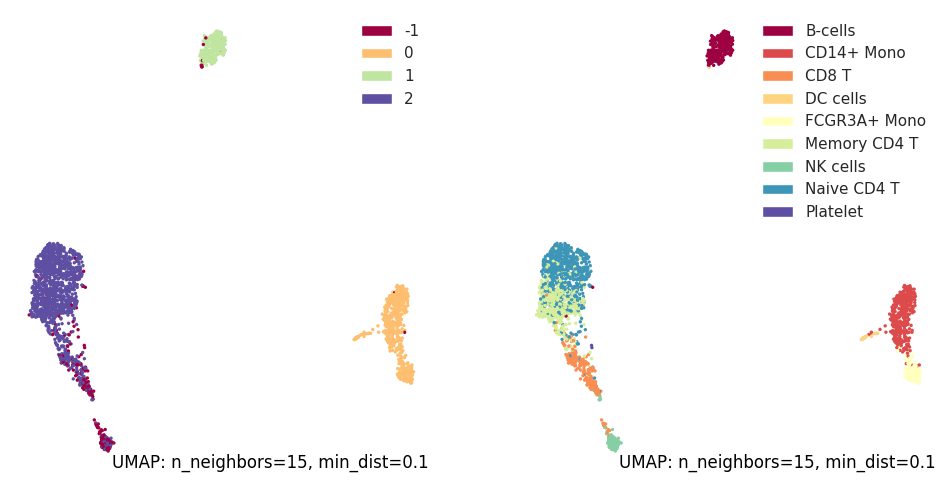

In [ ]:
# Run DBSCAN
clusterer = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=50,
    metric='euclidean',
    cluster_selection_method='leaf'
)
clusterer.fit(pca_transformed_data)

fig, axs = plt.subplots(
    1,2,
    figsize=(12, 6),
)

uplot.points(umap_obj, labels=np.array(clusterer.labels_), ax=axs[0])
uplot.points(umap_obj, labels=np.array(labels), ax=axs[1])

print(
    adjusted_rand_score(
        clusterer.labels_,
        labels
    )
)

plt.show()
# Hdbscan will fail to isolate cell types, probably because all of these small clusters are connected with dense areas

### Louvain

In [ ]:
%%capture
!apt install libcairo2-dev pkg-config python3-dev
!pip install igraph leidenalg cairocffi
!wget -O ch_11_funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/11/1119_funcs.py?raw=1

In [ ]:
from sklearn.neighbors import kneighbors_graph
import igraph as ig
from ch_11_funcs import plot_clust_stats

In [ ]:
# Create kdtree data structure for fast
# neighbour retreival
N_NEIGHBORS = 20

distance_matrix = kneighbors_graph(
    pca_transformed_data,
    n_neighbors=N_NEIGHBORS,
    mode='distance',
    metric='euclidean'
)

# we will use a radial basis function in order to transform Euclidean distances into similarities
# in order to find sigma we will use the median rule of thumb
sigma = np.median(distance_matrix.data)

# Transform distance matrix into adjacency matrix
distance_matrix.data = np.exp((distance_matrix.data)**2 / (2 * sigma**2))
adj_matrix = distance_matrix

# Create graph from adjacency matrix
g = ig.Graph.Weighted_Adjacency(
    adj_matrix,
    mode="undirected"
)

Resolution 0.2
Resolution 0.4
Resolution 0.6000000000000001
Resolution 0.8
Resolution 1.0
Resolution 1.2
Resolution 1.4000000000000001
Resolution 1.6
Resolution 1.8


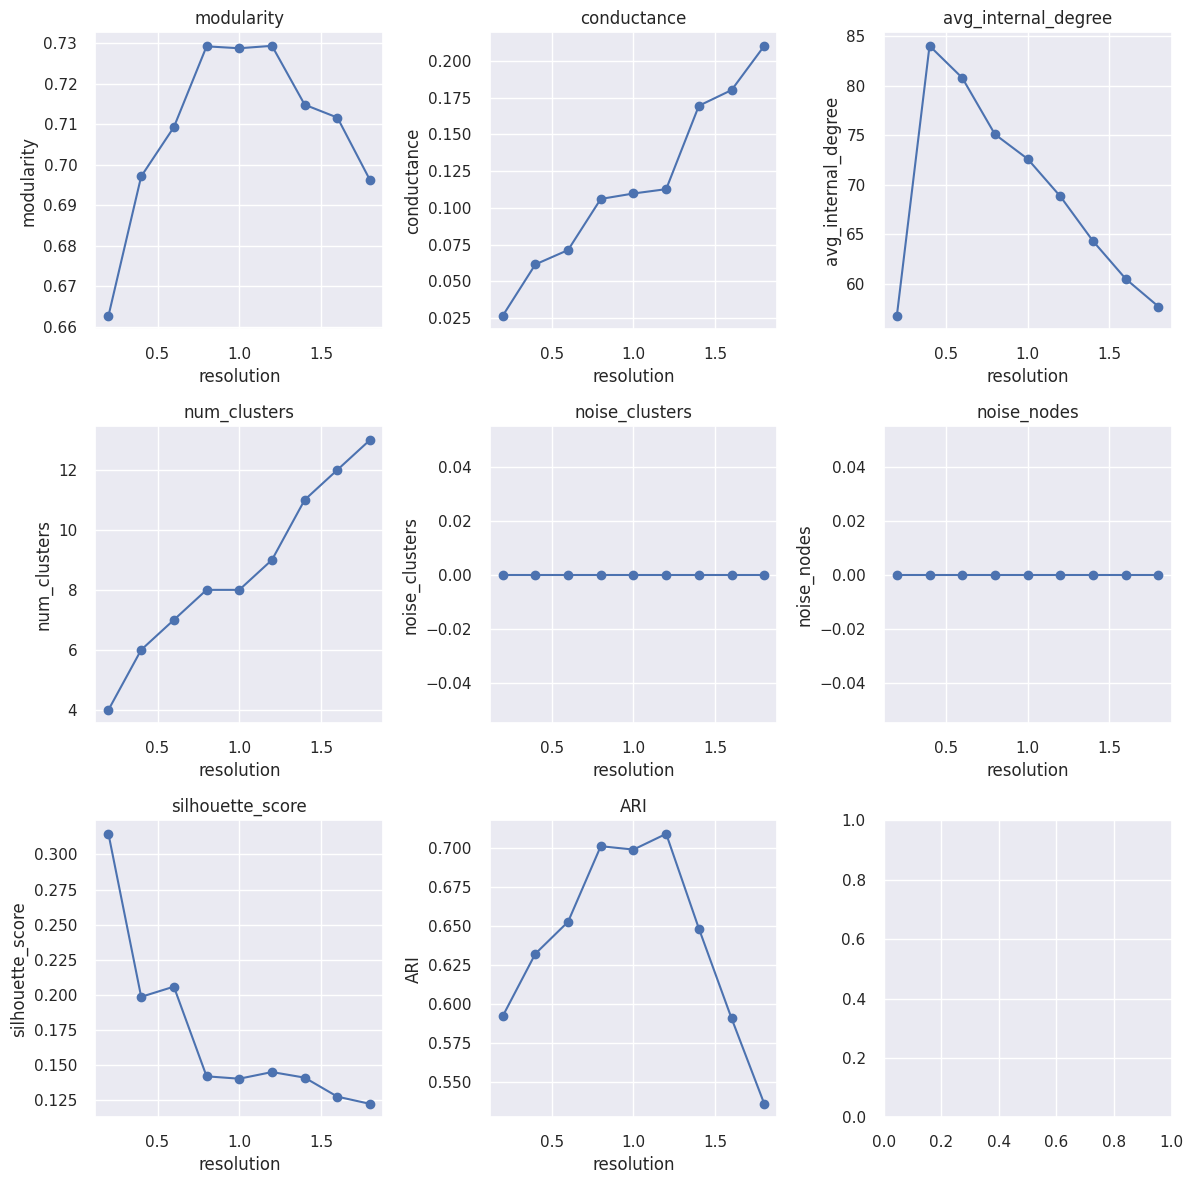

In [ ]:
plot_clust_stats(
    start_res=0.2,
    end_res=2,
    step=0.2,
    graph=g,
    original_data=pca_transformed_data,
    original_labels=labels
)
# the modularity is not bad
# it peaks around one, and we have the conductance growing all the time
# we have maximum average internal node degree here
# we have number of clusters that is growing
# it seems that the adjusted rand score will align with modularity pretty nicely
# and also the silhouette score will fall as we increase the resolution because we will move away from our tree, well separated groups

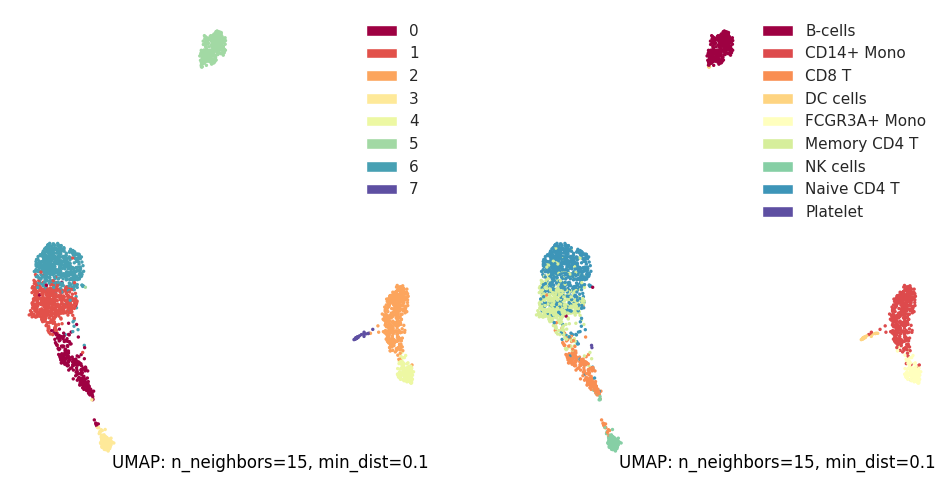

In [ ]:
ig_clusters = g.community_multilevel(resolution=1.1)

fig, axs = plt.subplots(
    1,2,
    figsize=(12, 6),
)

uplot.points(umap_obj, labels=np.array(ig_clusters.membership), ax=axs[0])
uplot.points(umap_obj, labels=np.array(labels), ax=axs[1])

plt.show()
# this is the best result so far because the algorithm will manage to identify cells in both this group (right top) and this group (right middle)

### SNN graph

In [ ]:
import itertools
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Find nearest neighbor ids
nearest_neigh = NearestNeighbors()
nearest_neigh = nearest_neigh.fit(pca_transformed_data)

neighbor_ids = nearest_neigh.kneighbors(
    pca_transformed_data,
    n_neighbors=N_NEIGHBORS,
    return_distance=False
)

In [ ]:
# Create the COO sparse adjacency matrix
# by using three lists
neighbor_sets = [set(row) for row in neighbor_ids]
data_point_ids = range(neighbor_ids.shape[0])
unique_pairs = list(itertools.combinations(data_point_ids, 2))

first_el = []
second_el = []
sim_value = []

jaccard_threshold = 0.1

for pair in unique_pairs:
    i = pair[0]
    j = pair[1]

    intersect_len = len(neighbor_sets[i].intersection(neighbor_sets[j]))
    union_len = 2*N_NEIGHBORS - intersect_len

    jaccard_similarity = intersect_len/union_len

    if jaccard_similarity > jaccard_threshold:
        first_el.append(i)
        second_el.append(j)
        sim_value.append(jaccard_similarity)

adj_matrix = coo_matrix(
    (sim_value, (first_el, second_el)),
    shape=(neighbor_ids.shape[0], neighbor_ids.shape[0])
)

# Load into igraph
g = ig.Graph.Weighted_Adjacency(adj_matrix, mode="max")

Resolution 0.1
Resolution 0.2
Resolution 0.30000000000000004
Resolution 0.4
Resolution 0.5
Resolution 0.6
Resolution 0.7000000000000001
Resolution 0.8
Resolution 0.9
Resolution 1.0
Resolution 1.1
Resolution 1.2000000000000002
Resolution 1.3000000000000003
Resolution 1.4000000000000001
Resolution 1.5000000000000002
Resolution 1.6
Resolution 1.7000000000000002
Resolution 1.8000000000000003
Resolution 1.9000000000000001


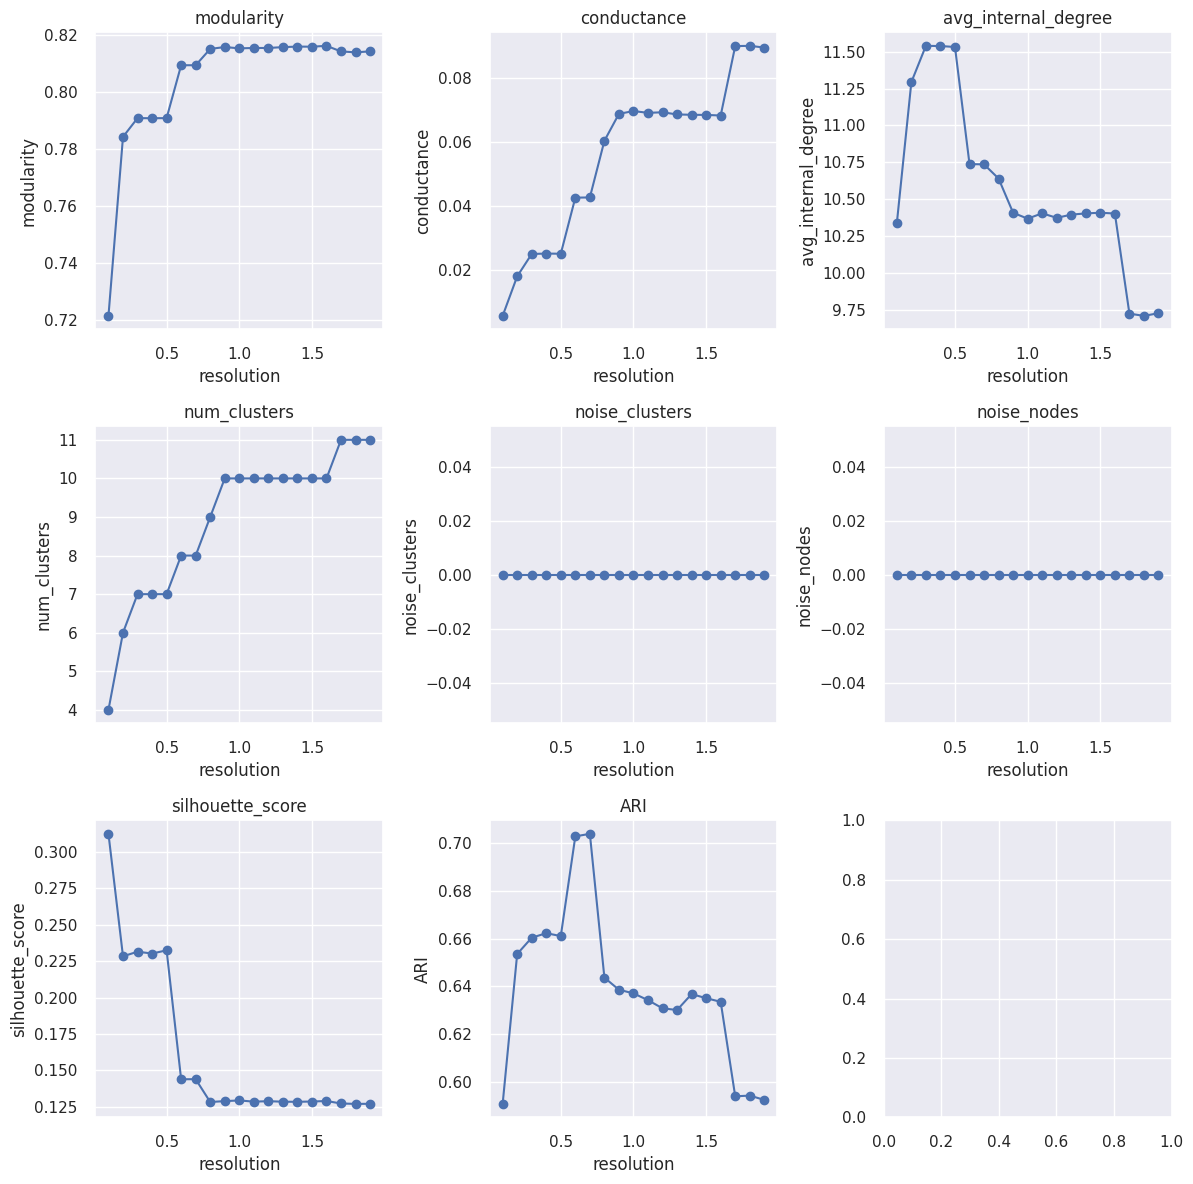

In [ ]:
plot_clust_stats(
    start_res=0.1,
    end_res=2,
    step=0.1,
    graph=g,
    original_data=pca_transformed_data,
    original_labels=labels
)
# the modularity is quite high and also becomes pretty stable after the resolution value that is approximately equal to 0.6
# the conductance will grow all the time
# the average internal node degree will be highest here
# number of clusters will grow all the time
# the silhouette score will fall as we increase resolution, which is pretty logical because we expect
# the silhouette score to be highest when we have three groups that are well isolated
# we have the adjusted rand score, that is not bad

<Axes: >

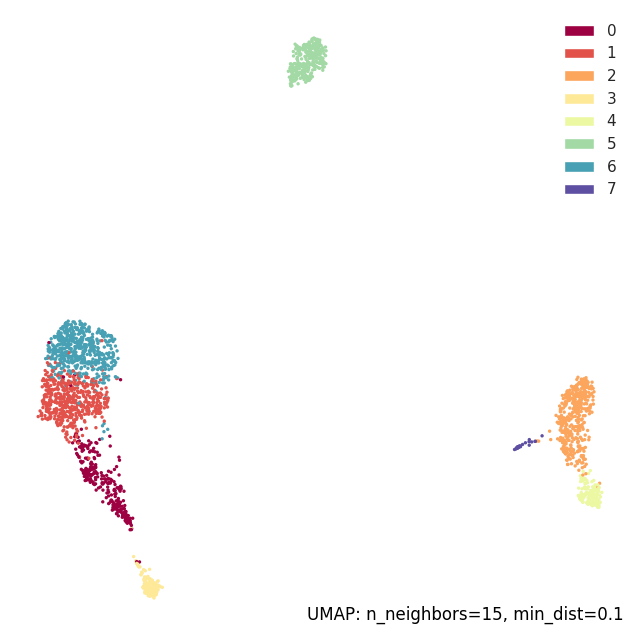

In [ ]:
ig_clusters = g.community_multilevel(
    resolution=0.6,
    weights='weight'
)

uplot.points(umap_obj, labels=np.array(ig_clusters.membership))
# the Louvain clustering coupled with SNN graph will perform pretty well and will manage to identify all of our major cell types

In [ ]:
# in this demo we have evaluated multiple clustering algorithms when it comes to clustering the single cell RNA data
# and we have managed to outperform K-means by using sophisticated methods like Louvain
# but we have another interesting observation
# even though Hdbscan is much more powerful and much more flexible than K-means,
# what happened here is that K-means actually outperformed Hdbscan due to the nature of the task and due to the nature of our algorithms